# Build the World Bank Knowledge Graph
This notebook builds a knowledge graph (KG) from documents obtained via the World Bank API in RDF. A verbose guide is available on my [knowledge hub](io.eriktuck.com).

In [1]:
import requests
import json
import pandas as pd
import numpy as np

## Get report metadata, including download link
Using the World Bank API, get a table of metadata from which we'll build the initial knowledge graph.

In [2]:
url = 'https://search.worldbank.org/api/v2/wds'
params = {
    'format': 'json',
    'display_title': '"sustainable development"',
    'rows': 20,
    'page':1
}

metadata_list = []

for i in range(1):
    response = requests.get(url, params=params)
    data = json.loads(response.content)
    for doc_id in data['documents']:
        metadata = data['documents'][doc_id]
        metadata_list.append(metadata)

    params['page'] += 1

df = pd.DataFrame(metadata_list)

In [3]:
df.head()

,id,last_modified_date,admreg,admreg_key,authors,count,count_key,docna,docty,docty_key,...,available_in,fullavailablein,url,EnvironmentalCategory,bdmdt,volnb,closedt,topicv3,origu,loan_no
0,34458416,2025-02-20T00:00:00Z,"Europe and Central Asia,Europe and Central Asia","119226,119226",{'0': {'author': 'zgen alar'}},Turkiye,82578,{'0': {'docna': 'Turkiye - EUROPE AND CENTRAL ...,Procurement Plan,739941,...,English,[],http://documents.worldbank.org/curated/en/0990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34455728,2025-02-13T00:00:00Z,"Latin America & Caribbean,Latin America & Cari...","119228,119228","{'0': {'author': 'Siegmann,Katharina'}}",Dominican Republic,82640,{'0': {'docna': 'Disclosable Version of the IS...,Implementation Status and Results Report,791001,...,English,[],http://documents.worldbank.org/curated/en/0990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34451551,2025-01-30T00:00:00Z,"Europe and Central Asia,Europe and Central Asia","119226,119226","{'0': {'author': 'Corsi,Anna'}}",Turkiye,82578,{'0': {'docna': 'Disclosable Version of the IS...,Implementation Status and Results Report,791001,...,English,[],http://documents.worldbank.org/curated/en/0990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34450050,2025-01-27T00:00:00Z,"Latin America & Caribbean,Latin America & Cari...","119228,119228","{'0': {'author': 'Paviot,Marie Caroline'}}",Brazil,82649,{'0': {'docna': 'Disclosable Restructuring Pap...,Project Paper,810308,...,English,[],http://documents.worldbank.org/curated/en/0990...,B,NaN,NaN,NaN,NaN,NaN,NaN
4,34449455,2025-02-14T00:00:00Z,NaN,NaN,{'0': {'author': 'World Bank'}},Honduras,82596,{'0': {'docna': 'Honduras - First Fiscal and C...,Program Document,640991,...,English,[],http://documents.worldbank.org/curated/en/0990...,NaN,2025-02-14T00:00:00Z,1,2025-02-14T00:00:00Z,"Financial Integrity m1326313 328,Investment Cl...",NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     20 non-null     object
 1   last_modified_date     20 non-null     object
 2   admreg                 19 non-null     object
 3   admreg_key             19 non-null     object
 4   authors                20 non-null     object
 5   count                  20 non-null     object
 6   count_key              20 non-null     object
 7   docna                  20 non-null     object
 8   docty                  20 non-null     object
 9   docty_key              20 non-null     object
 10  owner                  20 non-null     object
 11  projn                  20 non-null     object
 12  subsc                  13 non-null     object
 13  trustfund              14 non-null     object
 14  trustfund_key          14 non-null     object
 15  theme                  13

## Sanitize and simplify metadata

In [5]:
import unidecode

def sanitize_column(series: pd.Series) -> pd.Series:
    """Clean strings for use in RDF identifiers (URIs or keys)."""
    return (series.astype(str)
                  .map(unidecode.unidecode) # remove accents
                  .str.replace(r'\s+', '_', regex=True) # replace spaces
                  .str.replace("-", "_") # replace hyphens
                  .str.strip("_")  # remove trailing underscore
                  .replace('nan', np.nan)  # return nan
    )

columns_to_sanitize = ['docty', 'count', 'trustfund', 'trustfund_key',
                       'projn', 'projectid']
df[columns_to_sanitize] = df[columns_to_sanitize].apply(sanitize_column)

In [6]:
df.to_csv("raw.csv")

## Build KG with RDF
Using Resource Description Framework (RDF), build the KG. An alternative to RDF would be a property graph in Neo4j. We'll also use SPARQL to query Wikidata for entity linking and enrichment. For this demo, we focus only on country data.

In [7]:
from rdflib import Graph, RDF, RDFS, Namespace, URIRef, Literal
from rdflib.namespace import SKOS, XSD
from SPARQLWrapper import SPARQLWrapper, JSON
from tqdm import tqdm

# Set up RDF graph
g = Graph()
schema = Namespace("http://schema.org/")
wd = Namespace('http://www.wikidata.org/entity/')
ex = Namespace("http://worldbank.example.org/")

# Bind prefixes
prefixes = {
    'schema': schema,
    'wd': wd,
    'ex': ex,
    'skos': SKOS,
    'xsd': XSD
}
for p, ns in prefixes.items():
    g.bind(p, ns)

In [8]:
# Set up SPARQL connection
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setReturnFormat(JSON)
sparql.addCustomHttpHeader("User-Agent", "WorldBankKGBot/1.0 (eriktuck@gmail.com)")

### Match countries with Wikidata
Add the relevant country to the graph and match with Wikidata. We use two approaches to find the country in Wikidata:
- exact match: if the name in our metadata is exactly the same as the name in Wikidata, use SPARQL to pull the record
- fuzzy match: if no match is found in Wikidata, use the Wikidata API to search the country name we have and grab the first result

In [9]:
countries = df['count'].dropna().unique()
countries

array(['Turkiye', 'Dominican_Republic', 'Brazil', 'Honduras', 'Argentina',
       'India'], dtype=object)

In [10]:
def add_country_to_graph(qid_uri: str, country_code: str, label: str):
    """Adds a country instance to the RDF graph."""
    local_uri = ex[country_code]
    wikidata_uri = URIRef(qid_uri)

    g.add((local_uri, RDF.type, schema.Country))
    g.add((local_uri, schema.name, Literal(label, lang='en')))
    g.add((local_uri, schema.sameAs, wikidata_uri))


def query_via_sparql(query: str) -> str:
    """Runs any SPARQL query."""
    sparql.setQuery(query)
    results = sparql.query().convert()
    bindings = results['results']['bindings']
    if bindings:
        first_binding = bindings[0]
        # Get the first variable name from the binding
        var_name = next(iter(first_binding))
        return first_binding[var_name]['value']
    return None


def query_via_fuzzy_search(label: str) -> str:
    """Tries to find the QID via the Wikidata search API (fuzzy match)."""
    search_url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "search": label,
        "language": "en",
        "format": "json",
        "type": "item"
    }
    headers = {
        "User-Agent": "WorldBankKGBot/1.0 (eriktuck@gmail.com)"
    }
    response = requests.get(search_url, params=params, headers=headers)
    response.raise_for_status()
    search_results = response.json()

    if search_results['search']:
        qid = search_results['search'][0]['id']
        return f"http://www.wikidata.org/entity/{qid}"
    return None


# Main loop
for country in tqdm(countries):
    if not isinstance(country, str):
        continue

    label = country.replace('_', ' ')
    query = f"""
        SELECT ?country WHERE {{
            ?country wdt:P31 wd:Q6256 .
            ?country (rdfs:label|skos:altLabel) "{label}"@en .
        }}
        LIMIT 1
    """

    try:
        qid_uri = query_via_sparql(query)
        if qid_uri:
            add_country_to_graph(qid_uri, country, label)
        else:
            print(f"No exact match for: {label}. Trying fuzzy search...")
            try:
                qid_uri = query_via_fuzzy_search(label)
                if qid_uri:
                    add_country_to_graph(qid_uri, country, label)
                    print(f"Fuzzy match found: {label} → {qid_uri.split('/')[-1]}")
                else:
                    print(f"No fuzzy match found for: {label}")
            except Exception as fuzzy_error:
                print(f"Fuzzy search failed for {label}: {fuzzy_error}")
    except Exception as e:
        print(f"SPARQL query failed for {label}: {e}")


  0%|          | 0/6 [00:00<?, ?it/s]

No exact match for: Turkiye. Trying fuzzy search...


 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

Fuzzy match found: Turkiye → Q43


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


## Inspect KG
At this point we have a KG with a few countries. We'll visualize the KG in a few ways: 
- simple print statements to see each node
- NetworkX to visualize the graph schema
- Export an image

Once we enrich the graph with additional data from Wikidata, we'll visualize a single country.

### Print nodes

In [11]:
from collections import defaultdict

triples_by_subject = defaultdict(list)

for s, p, o in g:
    triples_by_subject[s].append((p, o))

for subject, po_list in triples_by_subject.items():
    print(f"\n🔹 {subject}")
    for predicate, obj in po_list:
        print(f"  ↳ {predicate} → {obj}")


🔹 http://worldbank.example.org/India
  ↳ http://schema.org/name → India
  ↳ http://schema.org/sameAs → http://www.wikidata.org/entity/Q668
  ↳ http://www.w3.org/1999/02/22-rdf-syntax-ns#type → http://schema.org/Country

🔹 http://worldbank.example.org/Honduras
  ↳ http://schema.org/sameAs → http://www.wikidata.org/entity/Q783
  ↳ http://www.w3.org/1999/02/22-rdf-syntax-ns#type → http://schema.org/Country
  ↳ http://schema.org/name → Honduras

🔹 http://worldbank.example.org/Dominican_Republic
  ↳ http://www.w3.org/1999/02/22-rdf-syntax-ns#type → http://schema.org/Country
  ↳ http://schema.org/sameAs → http://www.wikidata.org/entity/Q786
  ↳ http://schema.org/name → Dominican Republic

🔹 http://worldbank.example.org/Brazil
  ↳ http://www.w3.org/1999/02/22-rdf-syntax-ns#type → http://schema.org/Country
  ↳ http://schema.org/sameAs → http://www.wikidata.org/entity/Q155
  ↳ http://schema.org/name → Brazil

🔹 http://worldbank.example.org/Argentina
  ↳ http://schema.org/name → Argentina
  ↳ h

### NetworkX graph

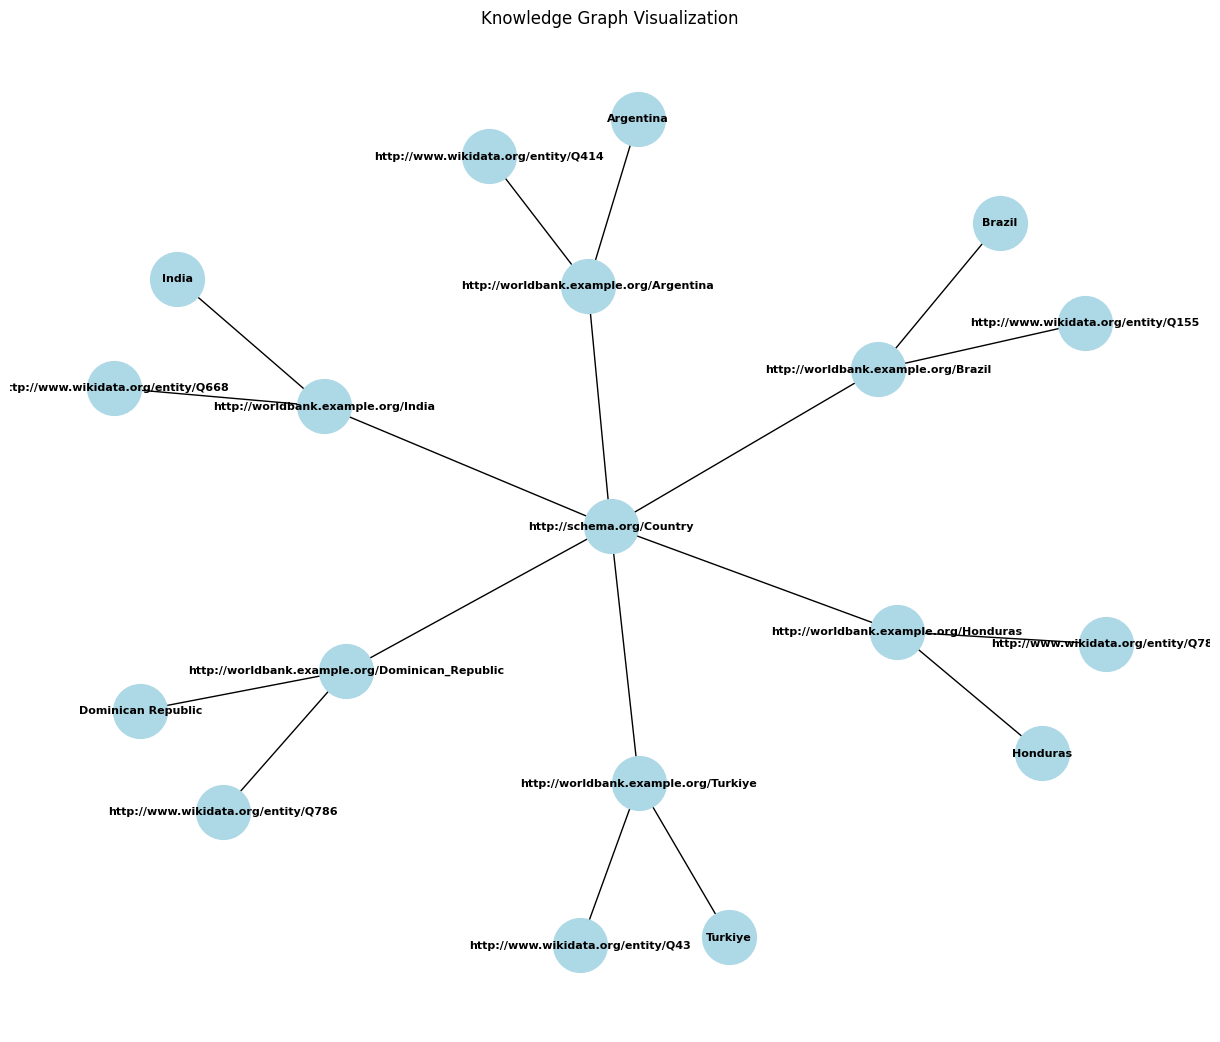

In [12]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import matplotlib.pyplot as plt
import networkx as nx

nx_graph = rdflib_to_networkx_graph(g)

plt.figure(figsize=(12, 10))
nx.draw(
    nx_graph,
    with_labels=True,
    node_size=1500,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
    arrows=True
)
plt.title("Knowledge Graph Visualization")
plt.show()

### Export image

In [211]:
from rdflib.tools.rdf2dot import rdf2dot
import io
import pydot

stream = io.StringIO()
rdf2dot(g, stream)
(graph,) = pydot.graph_from_dot_data(stream.getvalue())

# Save to file
graph.write_png("kg_diagram.png")  # or .svg, .pdf

## Enrich country data from Wikidata
Next we'll use Wikidata to add a few specified properties to each country, focusing on what would be relevant for our use cases. To improve performance and reduce calls to the API, we'll set up a cache to avoid redundant queries. 

In [13]:
import json
import os

CACHE_FILE = "wikidata_cache.json"

# Load cache if it exists
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r") as f:
        cache = json.load(f)
else:
    cache = {
        "countries": {},
        "entities": {}
    }

In [14]:
# Properties to add
PROPERTY_MAP = {
    "continent": "P30",
    "form_of_government": "P122",
    "political_system": "P1387",
    "currency": "P38",
    "official_language": "P37",
    "population": "P1082",
    "gdp_per_capita": "P2299"
}

def enrich_country_qid(qid: str, country_uri: URIRef, properties: dict):
    """
    Enriches a country node in the RDF graph with contextual properties from Wikidata.

    Caches enrichment data and reuses the cached triples to avoid redundant queries.

    Parameters:
        qid (str): The Wikidata QID of the country (e.g., "Q43" for Turkey).
        country_uri (rdflib.term.URIRef): The URI of the country node in the local knowledge graph.
        properties (dict): A dictionary like {'property': 'pid'}

    Side Effects:
        - Adds new triples to the global RDF graph `g`.
        - Updates the global cache `cache` with newly retrieved triples.

    Raises:
        Prints an error message if the SPARQL query fails or returns unexpected results.
    """
    if qid in cache["countries"]:
        for triple in cache['countries'][qid]:
            subj = country_uri
            pred = URIRef(triple["predicate"])
            obj = URIRef(triple["object"]) if triple["type"] == "uri" else Literal(triple["object"])
            g.add((subj, pred, obj))
        return
    
    query = f"""
    SELECT ?property ?value ?valueLabel WHERE {{
        VALUES ?property {{ { ' '.join(f'wdt:{pid}' for pid in properties.values()) } }}
        wd:{qid} ?property ?value .
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """
    try:
        sparql.setQuery(query)
        results = sparql.query().convert()
        cache_triples = []

        for result in results['results']['bindings']:
            prop_uri = result['property']['value']
            value = result['value']['value']
            label = result.get('valueLabel', {}).get('value', None)
            pred = URIRef(prop_uri)

            # Use wikidata URI if object is an entity
            if value.startswith("http://www.wikidata.org/entity"):
                obj = URIRef(value)
                obj_type = "uri"
            
                # Check if we've already added a label for this URIRef
                if value not in cache["entities"]:
                    if label:
                        g.add((obj, schema.name, Literal(label, lang="en")))
                        cache["entities"][value] = label

            else:
                obj = Literal(value)
                obj_type = "literal"
            
            g.add((country_uri, pred, obj))
            cache_triples.append({
                "predicate": str(prop_uri),
                "object": str(value),
                "type": obj_type
            })
            
        # Save to cache
        cache["countries"][qid] = cache_triples
            
    except Exception as e:
        print(f"Error enriching {qid}: {e}")

# Main loop
for country_uri in g.subjects(RDF.type, schema.Country):
    # Look for schema:sameAs link to Wikidata
    qid_uri = next(g.objects(country_uri, schema.sameAs), None)

    if qid_uri and "wikidata.org/entity/" in str(qid_uri):
        # Extract the QID from the URI
        qid = str(qid_uri).split("/")[-1]
        enrich_country_qid(qid, country_uri, PROPERTY_MAP)
    else:
        print(f"No Wikidata QID found for {country_uri}, skipping...")

# Write cache to file
with open(CACHE_FILE, "w") as f:
    json.dump(cache, f, indent=2)


## Visualize a single country 
Here we select a single country and visualize the knowledge graph with NetworkX to see how the properties were added.

http://schema.org/Country
http://www.wikidata.org/entity/Q43
http://www.wikidata.org/entity/Q48
http://www.wikidata.org/entity/Q256
http://www.wikidata.org/entity/Q172872
http://www.wikidata.org/entity/Q49892
http://www.wikidata.org/entity/Q179164


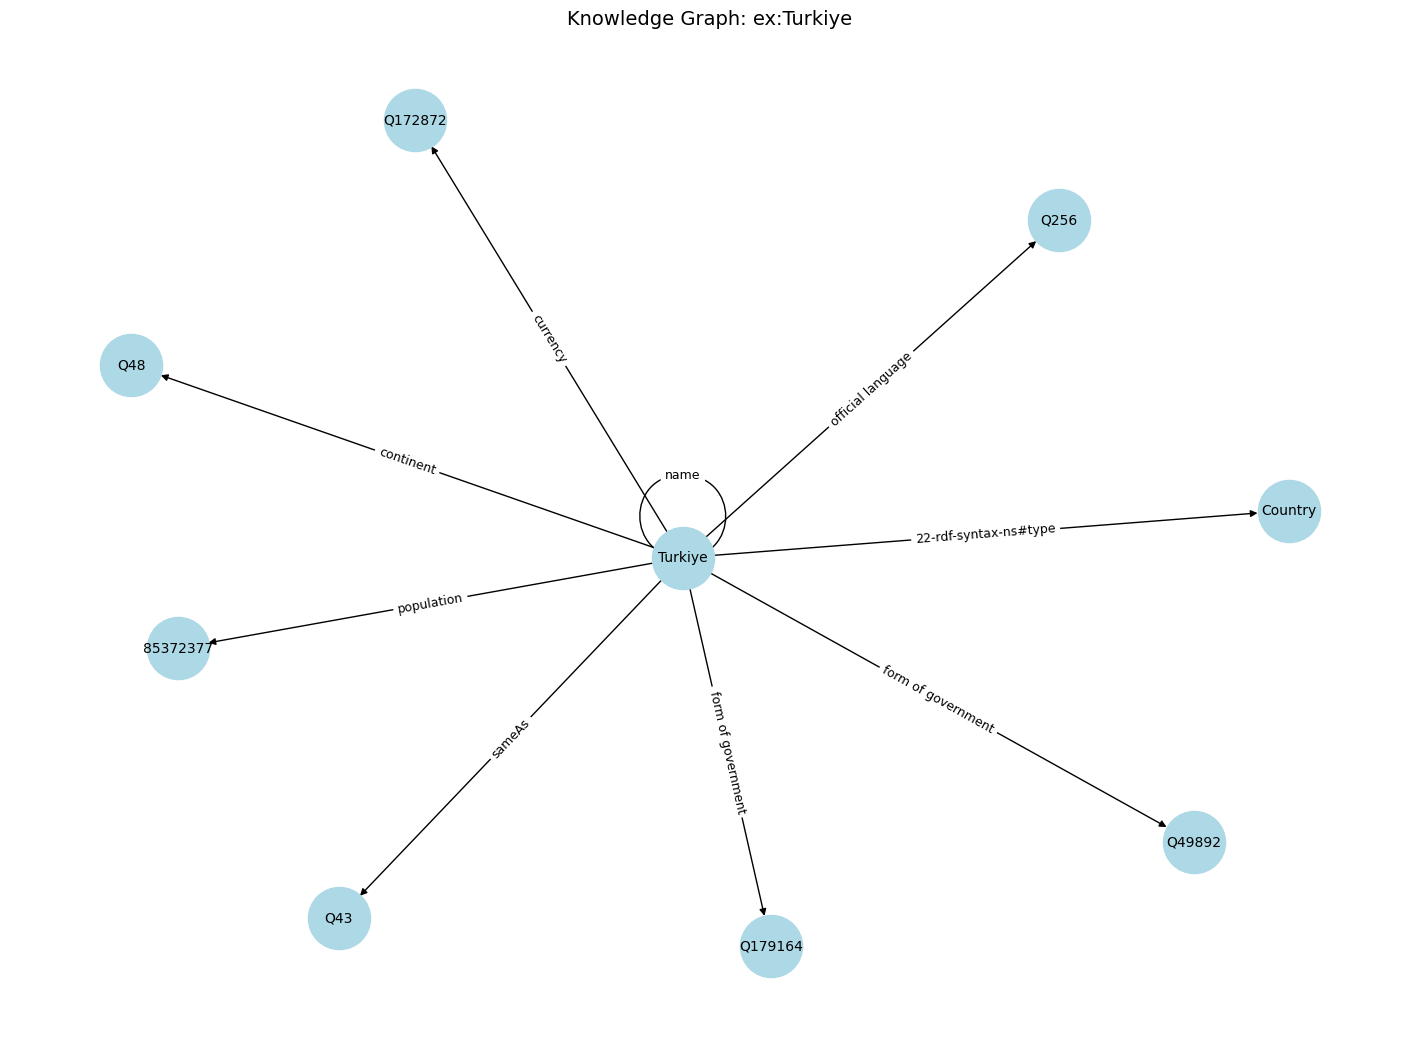

In [15]:
# Set your target country
country = "Turkiye"
country_uri = ex[country]

PID_TO_LABEL = {v: k.replace('_', ' ') for k, v in PROPERTY_MAP.items()}

# Extract all triples where the country is subject
triples = list(g.triples((country_uri, None, None)))

# Add schema:name triples for URIRefs
for _, _, obj in triples:
    if isinstance(obj, URIRef):
        label = g.value(subject=obj, predicate=schema.name)
        print(obj)
        if label:
            triples.append((obj, schema.name, label))

# Helper: get node label
def get_node_label(n):
    if isinstance(n, Literal):
        return str(n)
    label = g.value(subject=n, predicate=schema.name)
    if label:
        return str(label)
    return n.split("/")[-1]

# Helper: map P-code to readable label
def get_predicate_label(p):
    if isinstance(p, URIRef):
        pid = p.split("/")[-1]
        return PID_TO_LABEL.get(pid, pid)
    return get_node_label(p)

# Build the graph manually
G = nx.DiGraph()
for s, p, o in triples:
    s_label = get_node_label(s)
    o_label = get_node_label(o)
    p_label = get_predicate_label(p)

    G.add_node(s_label)
    G.add_node(o_label)
    G.add_edge(s_label, o_label, label=p_label)

# Draw it
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=1.2)

nx.draw(G, pos, with_labels=True,
        node_size=2000,
        node_color="lightblue",
        font_size=10,
        arrows=True)

# Add edge labels
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title(f"Knowledge Graph: ex:{country}", fontsize=14)
plt.axis("off")
plt.show()

## Continuing with other metadata
The following code adds a few other metadata properties to the graph. These are "free floating" in the sense that they are not connected yet. We'll connect them row-by-row in a subsequent step. However, we need to create the class that represents them and add each individual entry to the graph so it is available to connect later. We'll add
- Countries
- Documents
- Trustfunds
- Projects
- Authors

This is a helper function to get human readable labels

In [215]:
def get_entity_label(entity_code:int):
    """
    Get an entity label given an entity code from Wikidata
    UNUSED
    """

    # Construct the SPARQL query
    query = f"""
        SELECT ?label WHERE {{
            wd:{entity_code} rdfs:label ?label.
            FILTER (lang(?label) = 'en)
        }}
    """

    # Set the query and response format
    sparql.setQuery(query)

    # Execute the query and retrieve results
    results = sparql.query().convert()

    # Extract and return the entity label
    if ('results' in results and 
        'bindings' in results['results'] and
        results['results']['bindings']):
        label = results['results']['bindings'][0]['label']['value']
        return label
    
    return None

### Create country subclass

In [216]:
df['count'].unique()

array(['Turkiye', 'Dominican_Republic', 'Brazil', 'Honduras', 'Argentina',
       'India', nan], dtype=object)

In [217]:
def create_subclass_country(column:str):
    """
    Create the country subclass and add to graph.
    Note some entries are regions or continents.
    """
    newClass = URIRef(schema + "country")
    g.add((newClass, RDFS.label, Literal("country", lang='en')))
    
    for value in df[column].unique():
        if pd.notna(value):
            # Check Wikidata for a matching class
            query = f"""
              SELECT ?class ?label WHERE {{
                ?class wdt:P31 wd:Q6256 .
                ?class rdfs:label "{value}"@en .
                OPTIONAL {{ ?class skos:prefLabel ?label FILTER(lang(?label) = "en")}}
                FILTER(REGEX(STR(?class), "^http://www.wikidata.org/entity/Q[0-9]+$"))
              }}
            """

            # Set the query and response format
            sparql.setQuery(query)
            results = sparql.query().convert()

            # If there is a match, use the Wikidata class as a subclass
            if results['results']['bindings']:
                
                # Get URI from Wikidata
                uri = results['results']['bindings'][0]['class']['value']

                # Get the 'Q ID' which is the unique ID at the end of the URI
                qid = uri.split('/'[-1])
                country_label = value

                # Create a subclass for each country under the country class
                subclass = URIRef(schema + country_label.replace(' ', '_'))
                g.add((subclass, RDF.type, RDFS.Class))
                g.add((subclass, RDFS.subClassOf, newClass))

                # Update the "country_URI" column with the URI for the current country
                df.loc[df[column] == value, "country_URI"] = uri
                uri = URIRef(uri)

                # Define the URI for the new Wikidata URI property
                wd_URI_property = URIRef(schema + "wd_RUI")

                # Add the property to the RDF graph
                g.add((wd_URI_property, RDF.type, RDF.Property))

                # Add a label to the property
                label = Literal("Wikidata URI", lang="en")
                g.add((subclass, schema.wd_RUI, uri))

                # Add albel to each Wididata Q ID code that 
                # it is the Q ID for this particular country
                g.add((uri, RDFS.label, Literal(f"{country_label} wikidata code", lang="en")))
                g.add((subclass, RDFS.label, Literal(value, lang='en')))

            else:
                subclass = URIRef(schema + value.replace(' ', '_').replace('-', '_'))
                g.add((subclass, RDF.type, RDFS.Class))
                g.add((subclass, RDFS.subClassOf, newClass))
                g.add((subclass, RDFS.label, Literal(value, lang='en')))

### Create document subclass

In [231]:
def create_subclass_world_bank_document(column: str):
    newClass = URIRef(schema + "world_bank_document")
    g.add((newClass, RDFS.label, Literal("A document produced and written by the World Bank.", lang='en')))   

    uri_map = {}

    for value in df[column].unique():
        if isinstance(value, str) and pd.notna(value):
            # Check Wikidata for a matching class
            query = f"""
                SELECT ?class ?label WHERE {{
                    ?class rdfs:label "{value}"@en .
                    OPTIONAL {{ ?class skos:prefLabel ?label FILTER(lang(?label) = "en") }}
                    FILTER(REGEX(STR(?class), "^http://www.wikidata.org/entity/Q[0-9]+$"))
                }}
            """
            
            sparql.setQuery(query)
            results = sparql.query().convert()

            subclass = URIRef(schema + value.replace(' ', '_').replace('-','_'))
            g.add((subclass, RDF.type, RDFS.Class))
            g.add((subclass, RDFS.subClassOf, newClass))
            g.add((subclass, RDFS.label, Literal(value, lang='en')))
            uri_map[value] = str(subclass)  # store URI string

            if results['results']['bindings']:
                wd_class = results['results']['bindings'][0]['class']['value']
                wd_uri = URIRef(wd_class)

                wd_URI_property = URIRef(schema + "wd_URI")
                g.add((wd_URI_property, RDF.type, RDF.Property))
                g.add((wd_URI_property, RDFS.label, Literal("Wikidata URI", lang="en")))
                g.add((subclass, schema.wd_URI, wd_uri))
                g.add((wd_uri, RDFS.label, Literal("entity wikidata code", lang='en')))

    # Add the new column with mapped URIs
    df[f'{column}_URI'] = df[column].map(uri_map)

### Create trustfund subclass
Multiple trustfunds can be associated with a single record, they are presented as comma-separated values in the row.

In [232]:
def create_subclass_trustfund(column, ids=None):
    newClass = URIRef(schema + "trustfund")
    g.add((newClass, RDFS.label, Literal("trustfund")))

    # Define the id property
    id_property = schema.identifier
    g.add((id_property, RDF.type, RDF.Property))
    g.add((id_property, RDFS.label, Literal("Identifier")))

    # Associate the id property with the trustfund class
    g.add((id_property, RDFS.domain, newClass))

    for value in df[column].unique():
        if pd.notna(value):
            names = value.split(",")
            if ids is not None:
                for name in names:
                    newID = URIRef(schema + "trustfund" + "/" + str(name))
                    g.add((newID, RDF.type, newClass))
                    g.add((newID, RDFS.label, Literal(str(name))))
                    if name in ids:
                        id = ids[name]
                        # Create a URIRef for the trustfund_id resource
                        trustfund_id = URIRef(schema + "trustfund" + "/id/" + Literal(id, datatype=XSD.string))
                        g.add((newID, id_property, trustfund_id))
                        label = Literal(f"world bank trustfund ID for {name}", lang="en")
                        g.add((trustfund_id, RDFS.label, label))

### Create project subclass

In [233]:
def create_subclass_project(column):
    newClass = URIRef(schema + "project")
    g.add((newClass, RDFS.label, Literal("worldbank project")))

    for value in df[column].unique():
        if pd.notna(value):
            newID = URIRef(schema + "project/" + str(value).replace(" ","_").replace("-","_"))
            g.add((newID, RDF.type, newClass))
            g.add((newID, RDFS.label, Literal(str(value).replace(" ","_").replace("-","_"), lang='en')))

### Create author subclass
Authors are stored in a dictionary that needs to be parsed before adding.

In [234]:
import ast 

def create_subclass_authors(column):
    newClass = URIRef(schema + str(column))
    g.add((newClass, RDFS.label, Literal("worldbank authors")))

    seen_authors = set()

    for idx, value in df[column].items():
        if pd.notna(value):
            if isinstance(value, str):
                try:
                    value = ast.literal_eval(value)
                except Exception as e:
                    print(f"Skipping row {idx} due to parse error: {e}")
                    continue

            if isinstance(value, dict):
                for entry in value.values():
                    author_name = entry.get("author", "").strip()
                    if author_name and author_name not in seen_authors:
                        seen_authors.add(author_name)

                        author_uri = URIRef(schema + "author/" + author_name.replace(" ", "_"))
                        g.add((author_uri, RDF.type, newClass))
                        g.add((author_uri, RDFS.label, Literal(author_name, lang='en')))

In [235]:
# Create a dictionary that maps trustfund keys to trustfund names
trustfund_dict = {}
for i, row in df.dropna(subset=['trustfund', 'trustfund_key']).iterrows():
    keys = row['trustfund_key'].split(',')
    values = row['trustfund'].split(',')
    for key, value in zip(keys, values):
        trustfund_dict[key.strip()] = value.strip()

trustfund_dict

{'2396084': 'TF0C4083_Leveraging_property_and_geospatial_data_for_disaster_and_climate_resili',
 '2442455': 'TF0C5286_T00fcrkiye:_Leveraging_National_Spatial_Data_Infrastructure_for_Smart_C',
 '2463445': 'TF0C6078_GSCP___C2___Turkiye:_Geospatial_informed_Smart_City_Strategies_for_Publ',
 '2458413': 'TF0C5780_Technical_Assistance_for_Establishing_Science_Based_Policy_Options_for',
 '2458505': 'TF0C5873_Investing_in_the_Dominican_Republics_Green_Recovery_and_Blue_Economy',
 '1136287': 'TF098374_Supporting_the_Implementation_of_Phase_1_of_the_Matanza_Riachuelo_Basin',
 '2169235': 'TF0B8604_Circular_Economy_Actions_for_Non_Point_Source_Pollution_Reduction_at_th',
 '2230395': 'TF0B9831_Circular_Economy_for_Waste_Management_in_Province_of_Buenos_Aires',
 '2416574': 'TF0C4697_Haryana_Clean_Air_Project_for_Sustainable_Development:_Clean_Cooking_Pr',
 '2458503': 'TF0C5871_CH4D___Brazil___Methane_Action_in_Livestock_Practices'}

In [236]:
# Create a dictionary that maps project keys to project names
project_dict = {}
for i, row in df.dropna(subset=['projectid', 'projn']).iterrows():
    keys = row['projectid'].split(',')
    values = row['projn'].split(',')
    for key, value in zip(keys, values):
        project_dict[key.strip()] = value.strip()

project_dict

{'P179217': 'TR_Land_Management_Infrastructure_For_Green_And_Sustainable_Develo____P179217',
 'P500557': 'DO_Sustainable_Development_Dpl____P500557',
 'P167455': 'BR_Ceara_Rural_Sustainable_Development_And_Competitiveness_Phase_I____P167455',
 'P179909': 'HN_First_Fiscal_And_Climate_Transparency_And_Sustainability_Develo____P179909',
 'P105680': 'AR_Matanza_Riachuelo_Basin_Sustainable_Development_Project____P105680',
 'P502491': 'IN_Haryana_Clean_Air_And_Sustainable_Development_Program_P502491',
 'P175723': 'BR_Mato_Grosso_Sustainable_Development_Of_Family_Farming____P175723'}

In [237]:
create_subclass_country('count')
create_subclass_world_bank_document('docty')
create_subclass_trustfund('trustfund', trustfund_dict)
create_subclass_project('projn')
create_subclass_authors('authors')

## Save the graph
We'll save the graph out as a TTL (turtle) file and NT file.

In [238]:
g.serialize('world-bank-kg.ttl', format='turtle', prefixes=prefixes, encoding='utf-8')
g.serialize("world-bank-kg.nt", format="nt", prefixes=prefixes, encoding='utf-8')

<Graph identifier=N270c6b3ca3c44ec989685baef0bd4b9d (<class 'rdflib.graph.Graph'>)>

## Final inspection
Here we print out each triple in the graph for final inspection.

In [239]:
for subject, predicate, object in g:
    print(f"{subject} {predicate} {object}")

http://schema.org/trustfund/TF0C4697_Haryana_Clean_Air_Project_for_Sustainable_Development:_Clean_Cooking_Pr http://www.w3.org/2000/01/rdf-schema#label Trustfund: TF0C4697_Haryana_Clean_Air_Project_for_Sustainable_Development:_Clean_Cooking_Pr
http://worldbank.example.org/Brazil http://www.wikidata.org/prop/direct/P122 http://www.wikidata.org/entity/Q49892
http://schema.org/trustfund/TF0C4083_Leveraging_property_and_geospatial_data_for_disaster_and_climate_resili http://schema.org/countryOfOrigin http://schema.org/Turkiye
http://schema.org/trustfund/TF0C5286_T00fcrkiye:_Leveraging_National_Spatial_Data_Infrastructure_for_Smart_C http://www.w3.org/2000/01/rdf-schema#label TF0C5286_T00fcrkiye:_Leveraging_National_Spatial_Data_Infrastructure_for_Smart_C
http://schema.org/Program_Document http://www.w3.org/2000/01/rdf-schema#subClassOf http://schema.org/world_bank_document
http://schema.org/doc/Disclosable_Version_of_the_ISR__
____________Land_management_infrastructure_for_green_and_sustai

In [240]:
# Create author properties
authoredBy_uri = URIRef(schema + "authoredBy")
authored_uri = URIRef(schema + "authored")
g.add((authoredBy_uri, RDF.type, RDF.Property))
g.add((authored_uri, RDF.type, RDF.Property))
g.add((authoredBy_uri, RDFS.label, Literal("This document was authored by this author.")))
g.add((authored_uri, RDFS.label, Literal("This author wrote this document.")))

# Define 'part of' property
isPartOf_uri = URIRef(schema + "isPartOf")
g.add((isPartOf_uri, RDF.type, RDF.Property))
g.add((isPartOf_uri, RDFS.label, Literal("This entity is a part of another entity")))

# Define 'countryOfOrigin' property
countryOfOrigin_uri = URIRef(schema + "countryOfOrigin")
g.add((countryOfOrigin_uri, RDF.type, RDF.Property))
g.add((countryOfOrigin_uri, RDFS.label, Literal("Country that this document is about.")))

# Create instances for each document and add author property
for index, row in tqdm(df.iterrows()):
    if not pd.isnull(row['id']) and not pd.isnull(row['docty_URI']) and not pd.isnull(row['authors']):
        try:
            # Create the report instance
            instance = URIRef(schema + "doc/" + str(row['display_title']).replace(" ","_").replace("-","_"))
            g.add((instance, RDFS.label, Literal(str(row['display_title']), lang='en')))
            
            #Connect instances with types of documents
            doctype = URIRef(row['docty_URI'])
            g.add((instance, RDF.type, doctype))
    
            #Connect instances with country of origin
            if row['count'] != "nan":
                country = URIRef(schema + str(row['count']).replace(" ","_").replace("-","_"))
                g.add((instance, countryOfOrigin_uri, country))

            #Connect instances with projects
            if row['projn'] != "nan":
                project = URIRef(schema + "project/" + str(row['projn']).replace(" ","_").replace("-","_"))
                g.add((instance, isPartOf_uri, project))

            #Connect instances with trustfund_keys
            if row['trustfund'] != "nan":
                tf_values = row['trustfund'].split(",")
                for tf in tf_values:
                    trustfund_uri = URIRef(schema + "trustfund/" + str(tf).replace(" ","_").replace("-","_"))
                    g.add((trustfund_uri, RDFS.label, Literal(f"Trustfund: {tf}")))
                    g.add((instance, isPartOf_uri, trustfund_uri))
                    g.add((trustfund_uri, countryOfOrigin_uri, country))
                
            # Connect instances with authors
            author_dict = ast.literal_eval(row['authors'])
            for author_dict_entries in author_dict.values():
                author_name = author_dict_entries['author']
                author_uri = URIRef(schema + "author/" + author_name.replace(" ", "_"))
                g.add((instance, authoredBy_uri, author_uri))
                g.add((author_uri, authored_uri, instance))

        except:
            pass

21it [00:00, 5504.34it/s]


In [241]:
g.serialize('world-bank-kg.ttl', format='turtle', prefixes=prefixes, encoding='utf-8')
g.serialize("world-bank-kg.nt", format="nt", prefixes=prefixes, encoding='utf-8')

<Graph identifier=N270c6b3ca3c44ec989685baef0bd4b9d (<class 'rdflib.graph.Graph'>)>

In [242]:
# Step 1: Find the URI of Brazil in your ontology
brazil_uri = "<http://schema.org/Brazil>"  # Replace with the actual URI

# Step 2: Find the most relevant documents related to Brazil
documents_query = f"""
    PREFIX schema: <http://schema.org/>
    SELECT ?document
    WHERE {{
    ?document a/rdfs:subClassOf* schema:world_bank_document ;
        schema:countryOfOrigin {brazil_uri} .
}}
"""
qres = g.query(documents_query)
for row in qres:
    print(f"Document ID: {row.document}")

Document ID: http://schema.org/doc/Brazil___LATIN_AMERICA_AND
____________CARIBBEAN__P167455__Ceara_Rural_Sustainable_Development_and
____________Competitiveness_Phase_II___Procurement_Plan
Document ID: http://schema.org/doc/Disclosable_Version_of_the_ISR__
____________Ceara_Rural_Sustainable_Development_and_Competitiveness
____________Phase_II___P167455___Sequence_No_:_11
Document ID: http://schema.org/doc/Disclosable_Version_of_the_ISR__
____________Mato_Grosso_Sustainable_Development_of_Family_Farming__
____________P175723___Sequence_No_:_2
Document ID: http://schema.org/doc/Disclosable_Restructuring_Paper__
____________Ceara_Rural_Sustainable_Development_and_Competitiveness
____________Phase_II___P167455
